This is a notebook file to reproduce the data presented in arXiv:2206.10908 and perform neural networks simulation of scanning physical measurement data.  
  
We recommend to use TOC extension(available default in Jupyter Notebook later than ver.3.6). Reader may follow this document in such an order:
- 0. Preparation
- 1. Background problem of linear interpolation for estimation of target physical property from preliminary experimental data
-    (Appendix 1. Other examples of regressors in Scikit-learn)
- 2. Neural networks, using pre-trained model
- 3. Comparison of simulation by neural networks with experimental data taken in fine step
- 4. Building new neural networks model
- (Appendix 2. deeper neural networks model example)

# 0. For Google colab users, please start the cell below
This will download the required git and library, move to the default directory of Jupyter Notebook file in the repository

In [ ]:
!git clone https://github.com/kensei-te/mat_interp.git
%pip install tensorflow-addons==0.16.1
%pip install -quiet optuna
%cd mat_interp
%cd notebooks

# 0. For own PC users, please start the cell below

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,sys
sys.path.append("../../")
from mat_interp.model.viz_model import plot_entropy_curve
%load_ext autoreload
%autoreload 2

# 1. Visualization of raw experimental data and property calculation with simple linear interpolation

## **The problem**: Entropy calculation
To calculate the desired target physical property, sometimes a series of mathetical operations on the measurement data are required.
For example in Section 3.1 and 3.2 in the manuscript (arXiv:2206.10908), here we are interested in the magnetic entropy change ($\Delta$S$_{M}$), that can be deduced from magnetization (M (J/kg T)) measurements under various temperature (T (K)) and field (H (Oe)) by using following equation:

$$
\begin{equation}
\Delta S_{M} (T, \mu_{0}\Delta H = H_{f} - H_{i}) = \mu_{0}\int_{H_{i}}^{H_{f}} \left(\frac{\partial M}{\partial T}\right)_{H} dH
\end{equation}
$$

Below, we show that linear interpolation of the raw experimental data with coarse step leads to an 'spiky' oscilating artifact due to the lack of measurement in fine-enough field step so that linear interpolation almost follows the true non-linear behavior.

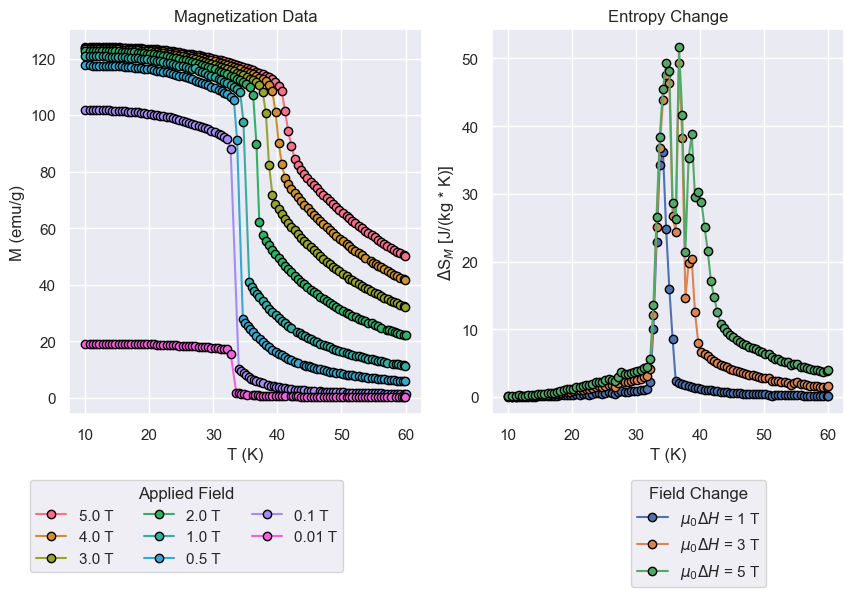

In [2]:
EXP_DATA = "../example_data/traindata_Section3_1.csv"
exp_df = pd.read_csv(EXP_DATA)

entropy_exp = plot_entropy_curve(data = exp_df, 
                                 temperature_column = "X1_demo1", 
                                 field_column="X2_demo1", 
                                 magnetization_column = "Y_demo1",
                                 return_entropy = True)

It is clear that with only those few fields measured (that is the often the common fields measured to calculate the entropy change assuming a material is of second-order), that those spiky values does not represent the true value. Specially, in the case of magnetocaloric materials, where the peak value of the entropy curve is used as base for comparison and calculation of different figure of merits (FOMs), this behavior can lead to a great overestimation of the target property $\Delta$S$_{M}$.

Other simple interpolation or approximation methods can be available using Scikit-learn, but it might not work successfully immediately for physical property measurement data without fine tuning, as those data often contain sudden changes and anistropic behaviors along features(measurement conditions). The tendency can be seen in Appendix 1. 

From the next cell, we will see that, by only using preliminary data with these few measured fields as training data, it is possible to simulate at what step is necessary for us to redo our measurement in order to have an accurate estimation of the entropy curve shape and values. Lets first, start by using a pre-trained model discussed in the paper, and later on lets move how to train the neural net that can do this.  

# 2. Simulating the data using the pre-trained neural networks model

Here we will show the simulation using the same model as discussed in the Section3.1 of the paper.

In [34]:
SAVED_WEIGHTS = "weights"
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow_addons.metrics import RSquare
model = tf.keras.models.load_model(SAVED_WEIGHTS)

## Prediction of target values for the same data points as training data, using loaded model

In [4]:
# Get the features from the training experimental dataset and simulate magnetization
exp_df = pd.read_csv(EXP_DATA) # R
mean = exp_df['Y_demo1'].mean()
std = exp_df['Y_demo1'].std()
train_features = exp_df.loc[:, ['X1_demo1', 'X2_demo1']].to_numpy()
simulated_magnetization = model.predict(train_features)
simulated_df = pd.DataFrame(data = train_features, columns=['t', 'h'])
simulated_df['m_sim'] = simulated_magnetization
simulated_df['m_sim'] = (simulated_df['m_sim']) * std + mean # Unscale target

2022-12-26 17:01:05.403113: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Text(0, 0.5, 'M (J/kg T)')

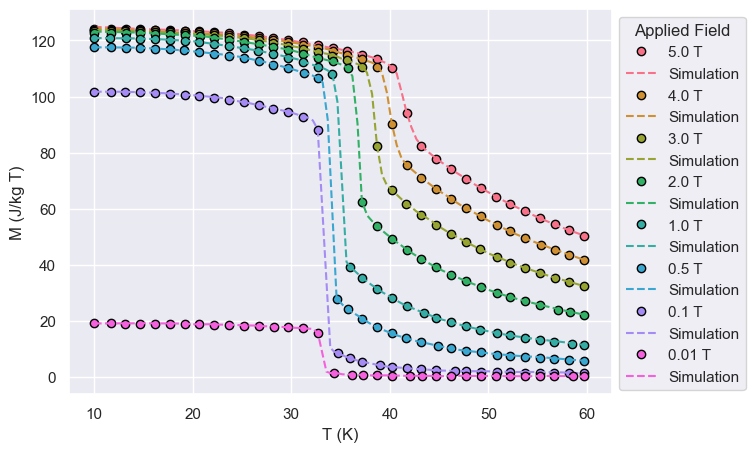

In [5]:
# Plotting the prediction

measured_fields = exp_df['X2_demo1'].unique()
WEIGHT = 0.61 * 1e-3  # note: the measured magnetization is (J/T) which depends also on sample mass.  To obtain magnetization (J/kg T), we need to divide by the sample mass.

fig, ax = plt.subplots(figsize=(7,5))
colors = sns.color_palette(palette="husl", n_colors=len(measured_fields))
for field, clr in zip(measured_fields, colors):
    df_plot = exp_df.query('X2_demo1 == @field')
    df_plot_sim = simulated_df.query('h == @field')
    plt.plot(df_plot['X1_demo1'], df_plot['Y_demo1'] / WEIGHT, 'o',label=f"{field / 1e4} T", color=clr, mec='black', markevery=3)
    plt.plot(df_plot_sim.t, df_plot_sim['m_sim'] / WEIGHT, '--',color=clr, label="Simulation", lw=1.5)
    
plt.legend(bbox_to_anchor=(1,1), title="Applied Field")
plt.xlabel("T (K)")
plt.ylabel("M (J/kg T)")


## Prediction of data for new field steps

Now let's simulate magnetization on new field steps, and see if the step can be fine enough to get rid of the artifitial spikes in $\Delta$S$_{M}$ estimated from magnetization.

In [9]:
from mat_interp.model.viz_model import generate_data
from mat_interp.utils.mce import interpolation_temperature

# Fields to interpolate in Oe
field_values = [100] + list(np.round(np.arange(2000, 50000 + 2000, 2000),2))

In [35]:
simulation_paramaters = {
    "x1_name": "t",
    "x2_name": "h",
    "y_name": "m",
    "x1_values": interpolation_temperature,
    "x2_values": field_values,
    "y_train": exp_df['Y_demo1'].to_numpy()
    
}

(25.0, 45.0)

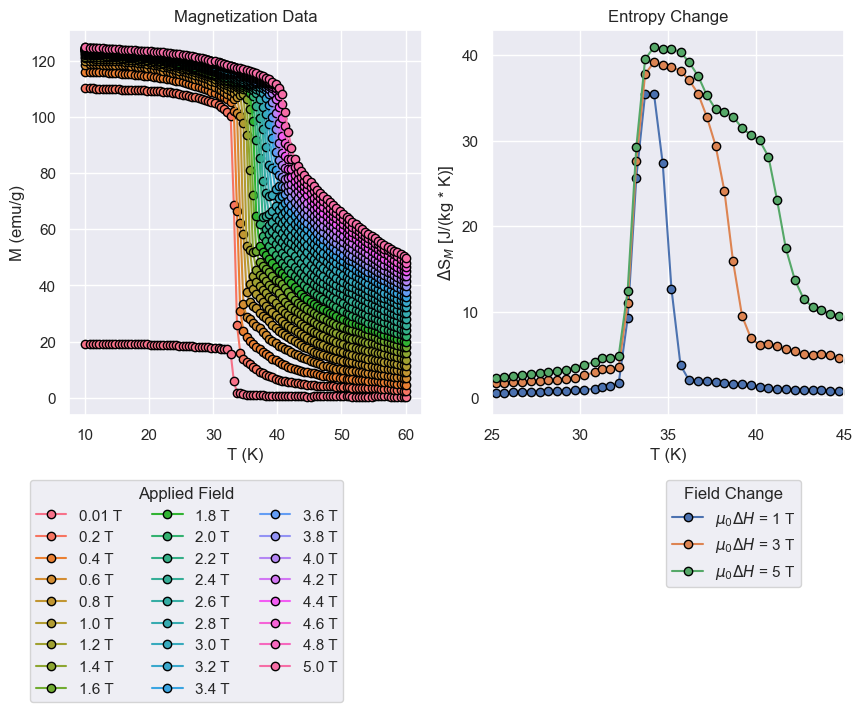

In [36]:
sim_data = generate_data(model=model,**simulation_paramaters)
sim_entropy = plot_entropy_curve(data=sim_data, 
                                 temperature_column="t", 
                                 field_column="h", 
                                 magnetization_column="m", 
                                 bbox_mag = (0.8, -0.15), 
                                 n_cols=3, 
                                 bbox_ds = (0.9, -0.15),
                                 return_entropy = True)
plt.xlim([25,45])

## Comparison of estimated $\Delta$S$_{M}$ between linear interpolation and neural networks simulation

Text(0, 0.5, '$\\Delta$S$_{M}$ [J/(kg K)]')

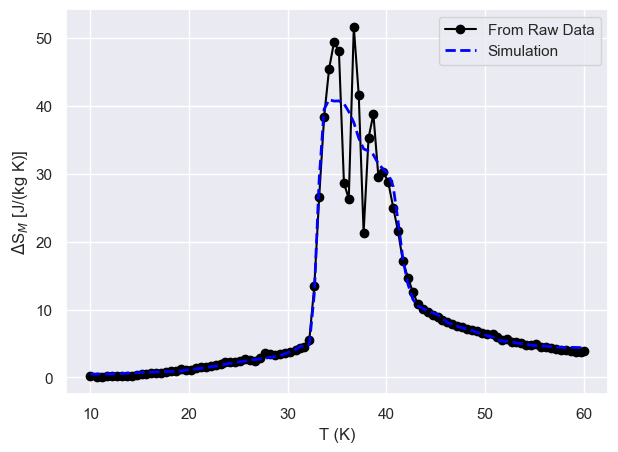

In [14]:
fields_to_plot = [5] # Plot 1 3 and 5 T
fig, ax = plt.subplots(figsize=(7,5))
for field in fields_to_plot:
    df_plot = sim_entropy.query("dh == @field")
    df_plot_2 = entropy_exp.query("dh == @field")
    plt.plot(df_plot_2.t, df_plot_2.ds,'o-', mec='black', label = "From Raw Data with linear interpolation", color='black')
    plt.plot(df_plot.t, df_plot.ds,'--', label = "Simulation", color='blue', lw=2)
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("T (K)")
plt.ylabel(r"$\Delta$S$_{M}$ [J/(kg K)]")

# 3. Comparison of simulation with the real (measured) data
We have just shown that if we simulate the data into 0.2 T steps, it would be enough to obtain a non-spiky curve that does not overestimate the value of $\Delta$S$_{M}$. Lets compare the simulated $\Delta$S$_{M}$ with that evaluated from the experimental data taken in the suggested field step.

We note a technical detail. Experimental data are already preprocessed, namely data points having long regression fit lower than threshold (typically 0.95) are removed and then data are linearly interpolated so that all data refers the same temperature range, which is necessary for performing integration operation to deduce $\Delta$S$_{M}$ from magnetization measurements [1].  

[1] Franco, V. (2021). Magnetocaloric Characterization of Materials. In Magnetic Measurement Techniques for Materials Characterization (pp. 697-726). Springer, Cham.

In [15]:
exp_data_fine = pd.read_csv("../example_data/experimental/fine_step.csv")

(25.0, 45.0)

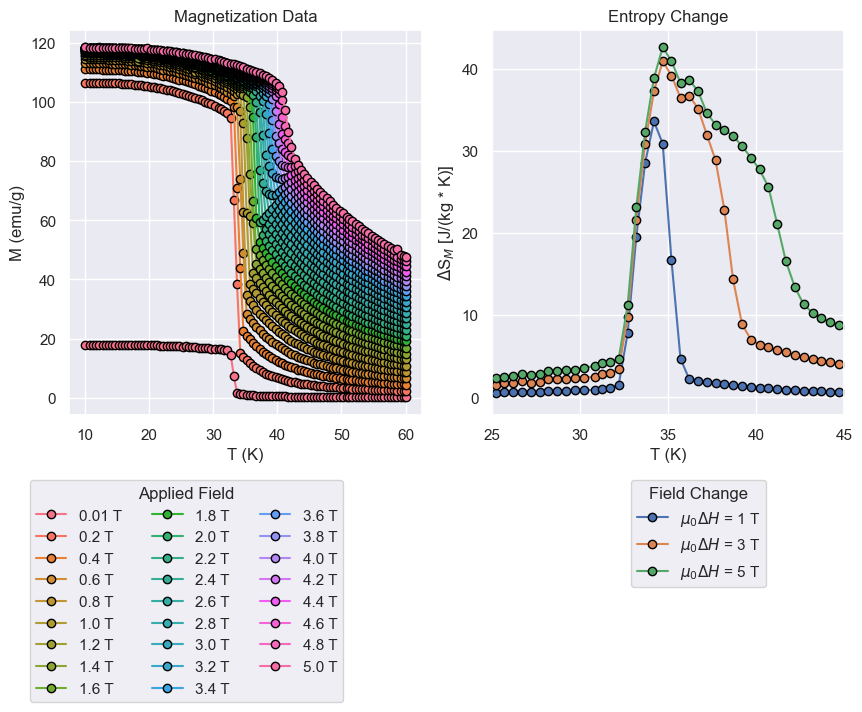

In [17]:
entropy_fine = plot_entropy_curve(exp_data_fine, 
                                  temperature_column="t", 
                                  magnetization_column="m", 
                                  field_column="h", 
                                  return_entropy=True)
plt.xlim([25,45])

## Lets compare now with the previously simulated data

> Note: The fine step data was taken from the same sample as the coarse one after a period of time has passed. The lower net magnetization observed is due to the the degradation of the sample with time (this experiments was done in a large time period over many months)

## Calculating the simulated entropy

Text(0, 0.5, '$\\Delta$S$_{M}$ [J/(kg K)]')

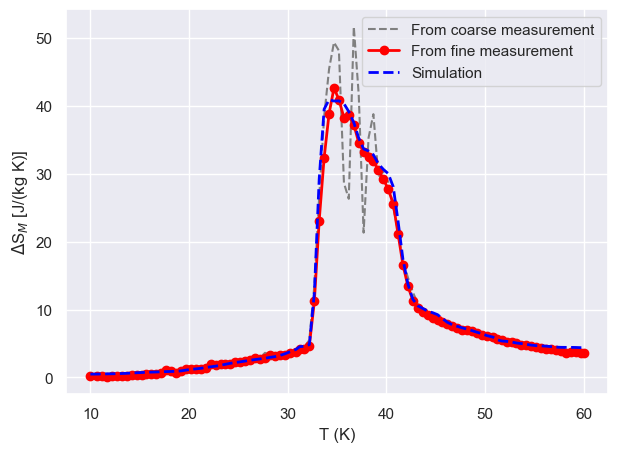

In [18]:
fields_to_plot = [5] # Plot 1 3 and 5 T
fig, ax = plt.subplots(figsize=(7,5))
for field in fields_to_plot:
    df_plot = sim_entropy.query("dh == @field")
    df_plot_2 = entropy_exp.query("dh == @field")
    df_plot_3 = entropy_fine.query("dh == @field")
    plt.plot(df_plot_2.t, df_plot_2.ds,'--', mec='black', label = "From coarse measurement", color='grey')
    plt.plot(df_plot_3.t, df_plot_3.ds,'o-', label = "From fine measurement", color='red', lw=2)
    plt.plot(df_plot.t, df_plot.ds,'--', label = "Simulation", color='blue', lw=2)
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("T (K)")
plt.ylabel(r"$\Delta$S$_{M}$ [J/(kg K)]")

# 4. Building a new neural network model by training data (preliminary experimental data with rough step)
Here we construct a new model through Baysian optimization of hyperparameters, using the magnetization measurement as training data (same data as shown above).  

We note here for clarity that the learning of weights and biases in single trial is performed to minimize mean squared errors (MSEs) by using "solver" specified below(default is Adam), as MSE is the default loss function of Keras in Tensorflow.  Whereas, here the Baysian optimization of hyperparameters are performed to maximize R2-score derived from each trial.

In [3]:
from mat_interp.model.train_model import load_train_data, optimize_neural_net

# Setup the data (same as before) and the target columsn
EXP_DATA = "../example_data/traindata_Section3_1.csv"
feature_columns = ['X1_demo1', 'X2_demo1']
target_column = ['Y_demo1']
X_train, y_train = load_train_data(EXP_DATA, feature_columns, target_column)

In [36]:
# Search settings.  For detail of the settings, refer to the document for "optimize_neural_net" shown below ("shift"+"tab").
nn_settings = {
    "epochs": 500,
    "solver": "Adam",
    "X_train": X_train,
    "y_train": y_train,
    "num_trials": 20,
    "working_dir": "nn_search",
}

# Run search
optimize_neural_net(**nn_settings)

[I 2022-12-21 10:19:43,970] A new study created in memory with name: optuna_NNtemp
/home/wilson/anaconda3/envs/mat_interp/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


Starting optimization process...


2022-12-21 10:19:59.699756: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: nn_search/modeltrial_9/assets


[I 2022-12-21 10:20:00,222] Trial 9 finished with value: 0.9454724192619324 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 120, 'starting_lr': 0.002389720131688548, 'batchsize': 128}. Best is trial 9 with value: 0.9454724192619324.


INFO:tensorflow:Assets written to: nn_search/modeltrial_11/assets


[I 2022-12-21 10:20:04,923] Trial 11 finished with value: 0.9821344614028931 and parameters: {'num_layers': 10, 'num_nodes_per_layer': 176, 'starting_lr': 0.0023628679544676814, 'batchsize': 64}. Best is trial 11 with value: 0.9821344614028931.
[I 2022-12-21 10:20:06,401] Trial 15 pruned. Trial was pruned at epoch 50.
[I 2022-12-21 10:20:07,625] Trial 7 pruned. Trial was pruned at epoch 50.
[I 2022-12-21 10:20:09,181] Trial 13 pruned. Trial was pruned at epoch 50.
[I 2022-12-21 10:20:09,290] Trial 0 pruned. Trial was pruned at epoch 50.
[I 2022-12-21 10:20:10,999] Trial 14 pruned. Trial was pruned at epoch 50.
[I 2022-12-21 10:20:11,277] Trial 3 pruned. Trial was pruned at epoch 50.
[I 2022-12-21 10:20:11,482] Trial 5 pruned. Trial was pruned at epoch 50.
[I 2022-12-21 10:20:13,014] Trial 1 pruned. Trial was pruned at epoch 50.
[I 2022-12-21 10:20:18,808] Trial 16 pruned. Trial was pruned at epoch 100.


INFO:tensorflow:Assets written to: nn_search/modeltrial_8/assets


[I 2022-12-21 10:20:20,428] Trial 8 finished with value: 0.9999804496765137 and parameters: {'num_layers': 3, 'num_nodes_per_layer': 139, 'starting_lr': 0.0023577974044391476, 'batchsize': 64}. Best is trial 8 with value: 0.9999804496765137.
[I 2022-12-21 10:20:21,491] Trial 18 pruned. Trial was pruned at epoch 50.
[I 2022-12-21 10:20:25,042] Trial 12 pruned. Trial was pruned at epoch 100.


INFO:tensorflow:Assets written to: nn_search/modeltrial_4/assets


[I 2022-12-21 10:20:33,104] Trial 4 finished with value: 0.9999931454658508 and parameters: {'num_layers': 5, 'num_nodes_per_layer': 160, 'starting_lr': 0.003379608639608053, 'batchsize': 128}. Best is trial 4 with value: 0.9999931454658508.


INFO:tensorflow:Assets written to: nn_search/modeltrial_17/assets


[I 2022-12-21 10:20:37,102] Trial 17 finished with value: 0.9999831318855286 and parameters: {'num_layers': 8, 'num_nodes_per_layer': 111, 'starting_lr': 0.003255750574518462, 'batchsize': 64}. Best is trial 4 with value: 0.9999931454658508.
[I 2022-12-21 10:20:37,414] Trial 19 pruned. Trial was pruned at epoch 100.
[I 2022-12-21 10:20:37,862] Trial 10 pruned. Trial was pruned at epoch 200.
[I 2022-12-21 10:20:38,159] Trial 2 pruned. Trial was pruned at epoch 200.


INFO:tensorflow:Assets written to: nn_search/modeltrial_6/assets


[I 2022-12-21 10:20:39,354] Trial 6 finished with value: 0.9999789595603943 and parameters: {'num_layers': 10, 'num_nodes_per_layer': 186, 'starting_lr': 0.0023103065654751995, 'batchsize': 64}. Best is trial 4 with value: 0.9999931454658508.


Optimization Finished.
Fineshed cleaning up files.. best model kept at nn_search/modeltrial_4


## Let's check the best model

(25.0, 45.0)

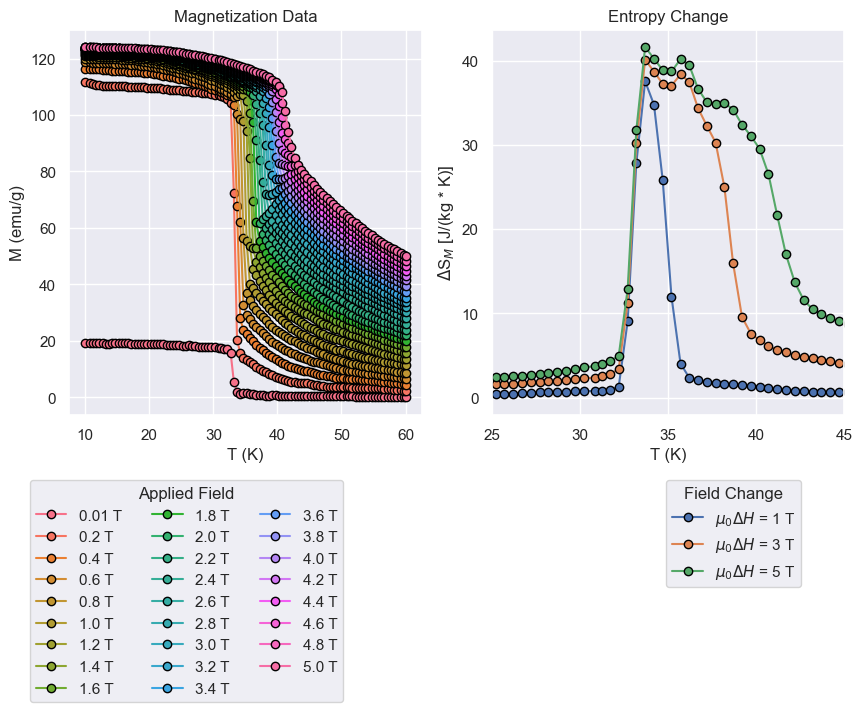

In [37]:
SAVED_WEIGHTS = "nn_search/modeltrial_28/"# put corresponding number of trial of best model
model = tf.keras.models.load_model(SAVED_WEIGHTS)
sim_data = generate_data(model=model,**simulation_paramaters)
# otherwise, prepare a tidy pandas dataframe (X_predict), normalize them, then sim_data = model.predict(X_predict)
new_model_entropy = plot_entropy_curve(data=sim_data, 
                                       temperature_column="t", 
                                       field_column="h", 
                                       magnetization_column="m", 
                                       bbox_mag = (0.8, -0.15), 
                                       n_cols=3, 
                                       bbox_ds = (0.9, -0.15), 
                                       return_entropy = True)
plt.xlim([25,45])

## Finally comparing all the models

Text(0, 0.5, '$\\Delta$S$_{M}$ [J/(kg K)]')

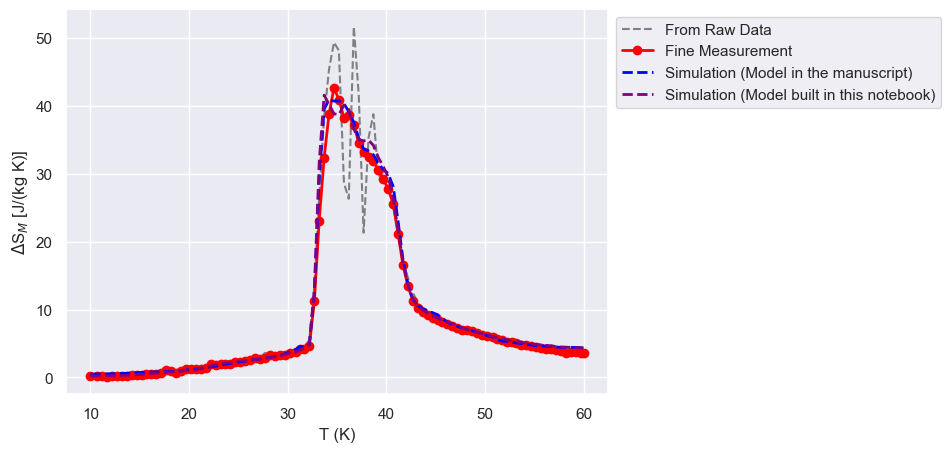

In [38]:
fields_to_plot = [5] # Plot 1 3 and 5 T
fig, ax = plt.subplots(figsize=(7,5))
for field in fields_to_plot:
    df_plot = sim_entropy.query("dh == @field")
    df_plot_2 = entropy_exp.query("dh == @field")
    df_plot_3 = entropy_fine.query("dh == @field")
    df_plot_5 = new_model_entropy.query("dh == @field")
    plt.plot(df_plot_2.t, df_plot_2.ds,'--', mec='black', label = "From Raw Data", color='grey')
    plt.plot(df_plot_3.t, df_plot_3.ds,'o-', label = "Fine Measurement", color='red', lw=2)
    plt.plot(df_plot.t, df_plot.ds,'--', label = "Simulation (Model in the manuscript)", color='blue', lw=2)
    plt.plot(df_plot_5.t, df_plot_5.ds,'--', label = "Simulation (Model built in this notebook)", color='purple', lw=2)
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("T (K)")
plt.ylabel(r"$\Delta$S$_{M}$ [J/(kg K)]")

# Appendix 1: Comparison with regressors available on Scikit-learn

Here we will show the usage of scikit-learn modules such as RandomForest Regression, Linear Regression and MLP Regressor, as an example of simpler approach.

## Building models

In [28]:
from mat_interp.model.train_model import load_train_data
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from mat_interp.model.viz_model import generate_data

# Setup the data (same as before) and the target columsn
EXP_DATA = "../example_data/traindata_Section3_1.csv"
feature_columns = ['X1_demo1', 'X2_demo1']
target_column = ['Y_demo1']
X_train, y_train = load_train_data(EXP_DATA, feature_columns, target_column)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [29]:
scaler = StandardScaler()
pipe_model = lambda pipe_model: Pipeline([['scaler', scaler], ['model', pipe_model]])

In [30]:
# linear = pipe_model(LinearRegression())
rf = pipe_model(RandomForestRegressor(n_jobs = - 1))
nn_skl = pipe_model(MLPRegressor(hidden_layer_sizes=(193,) *6, 
             learning_rate_init=0.00434, 
             max_iter = 500, 
             early_stopping=True, 
             ))# same hyperparameters as those in the saved model for tensorflow
# guassian_process = pipe_model(GaussianProcessRegressor())
kernel_ridge = pipe_model(KernelRidge(kernel = "rbf"))# KRR, default kernel is linear, here we choose rbf

In [40]:
models = [("random_forest", rf), 
          ("nn_scikit", nn_skl), 
          ("krr", kernel_ridge)
         ]
results = {}
simulation_paramaters_sklearn = {
    "x1_name": "t",
    "x2_name": "h",
    "y_name": "m",
    "x1_values": interpolation_temperature,
    "x2_values": field_values,
    "y_train": None
    
}

Training random_forest....


/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/pipeline.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Finished!
Training nn_scikit....


/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Finished!
Training krr....


/home/pedrobcst/anaconda3/envs/mat_interp/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Finished!


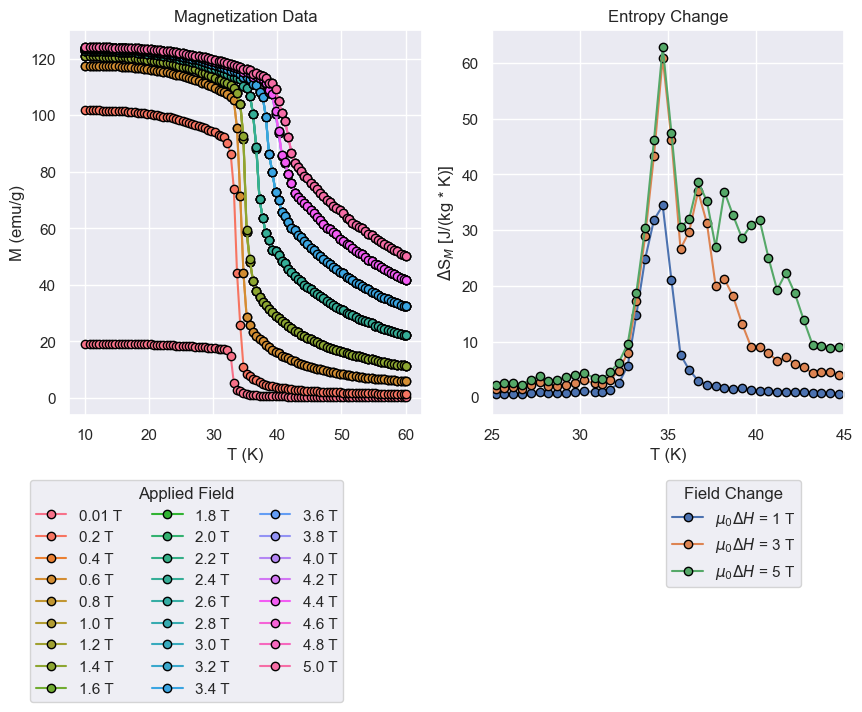

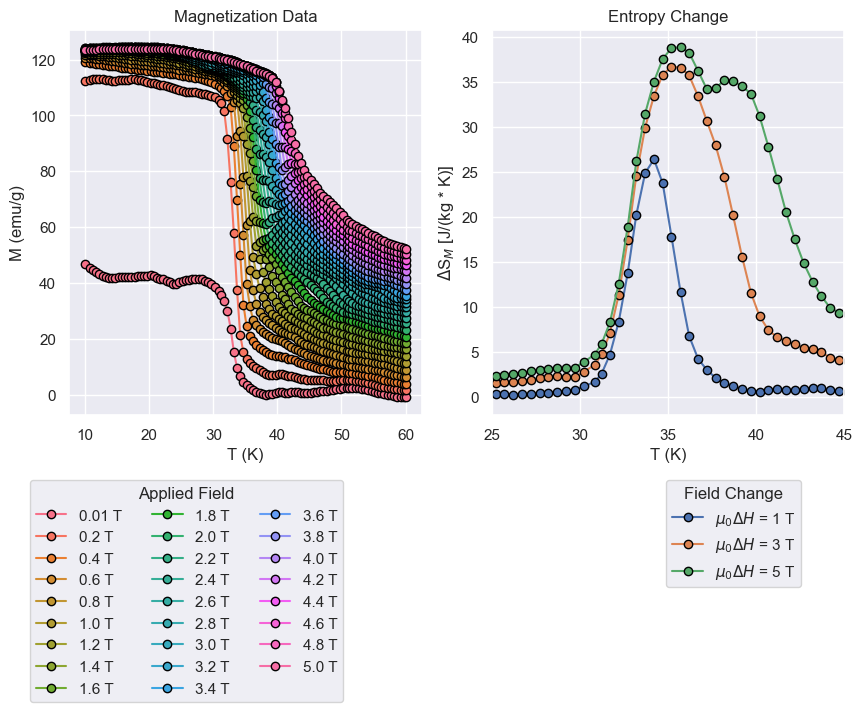

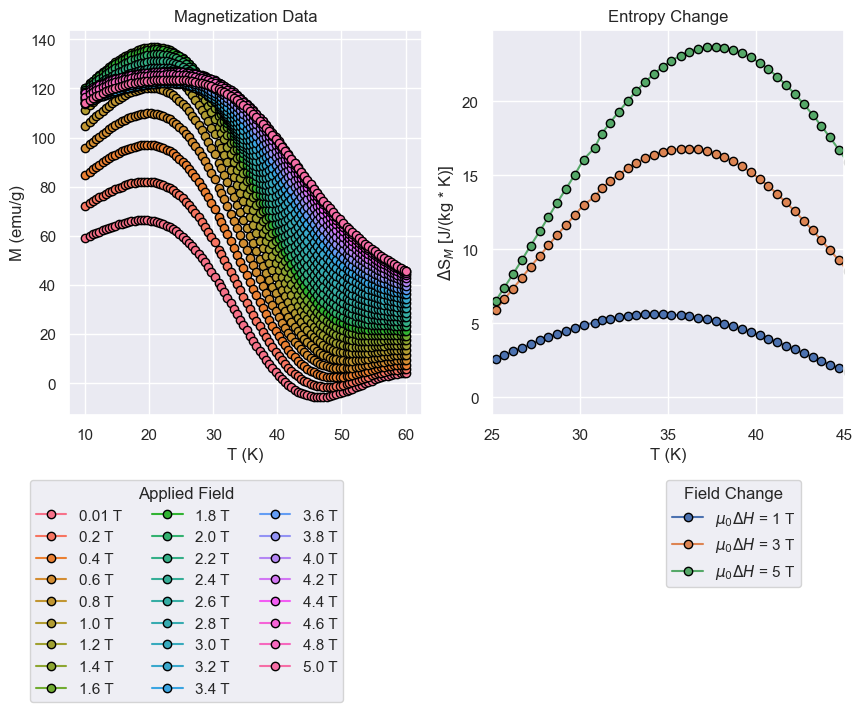

In [41]:
for model_type, model in models:
    print(f"Training {model_type}....")
    model.fit(X_train, y_train)
    gen_data = generate_data(model = model, **simulation_paramaters_sklearn)
    entropy = plot_entropy_curve(data=gen_data, 
                       temperature_column="t", 
                       field_column="h", 
                       magnetization_column="m", 
                       bbox_mag = (0.8, -0.15), 
                       n_cols=3, bbox_ds = (0.9, -0.15),
                       return_entropy = True)
    results[model_type] = (entropy, gen_data, model)
    plt.xlim([25,45])
    print("Finished!")

## Comparison of predicted results between models and experimental data

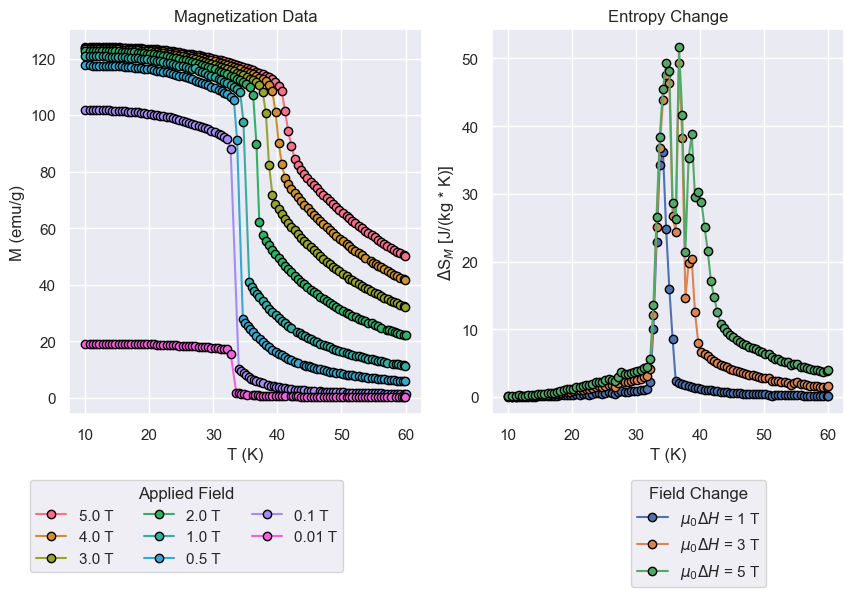

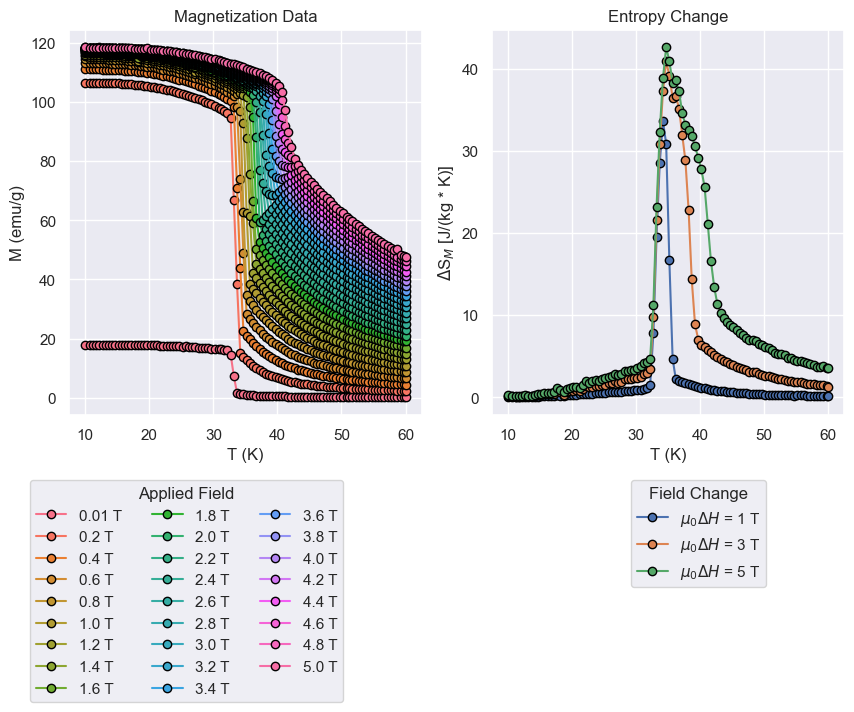

In [42]:
import seaborn as sns

EXP_DATA = "../example_data/traindata_Section3_1.csv"
exp_df = pd.read_csv(EXP_DATA)
entropy_exp = plot_entropy_curve(data = exp_df, 
                                 temperature_column = "X1_demo1", 
                                 field_column="X2_demo1", 
                                 magnetization_column = "Y_demo1",
                                 return_entropy = True)
exp_data_fine = pd.read_csv("../example_data/experimental/fine_step.csv")
entropy_fine = plot_entropy_curve(exp_data_fine, temperature_column="t", magnetization_column="m", field_column="h", return_entropy=True)

ds_dataframes = [
    (entropy_exp, 'Exp. (Coarse)'),
    (entropy_fine, 'Exp. (Fine)'),
    (results['krr'][0], 'Kernel Regression'),
    (results['random_forest'][0], 'Random Forest'),
    (results['nn_scikit'][0], 'Neural Net. (sklearn)')
]
colors = ["grey", "red"] + list(sns.color_palette(palette = "dark", n_colors=len(ds_dataframes) - 2))
paramaters = ['--', 'o-', 'v-'] + ['-.']*(len(ds_dataframes) - 3)

(27.0, 48.0)

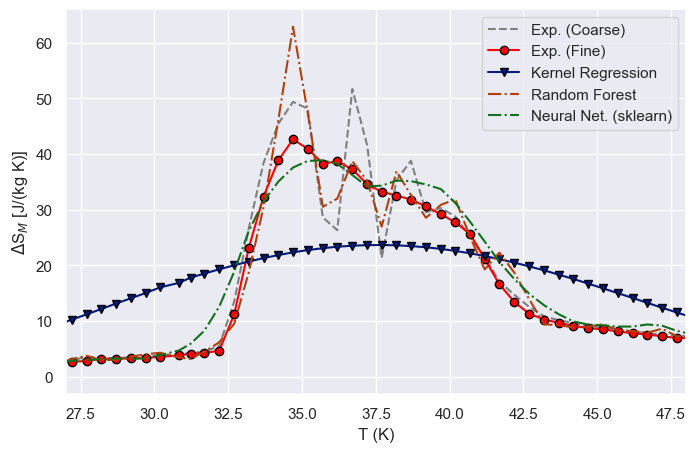

In [43]:
fields_to_plot = [5] # Plot 1 3 and 5 T
fig, ax = plt.subplots(figsize=(8,5))
for (ds_df, label), color, param in zip(ds_dataframes, colors, paramaters):
    df_plot = ds_df.query("dh == @fields_to_plot")
    plt.plot(df_plot.t, df_plot.ds,param, mec='black', label = label, color=color)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("T (K)")
plt.ylabel(r"$\Delta$S$_{M}$ [J/(kg K)]")
plt.xlim([27,48])

# Appendix 2: deeper model
In the code, we can change number of nodes & layers and regularization methods.  We can also do Baysian optimization of those parameters as well.  Therefore, deeper layer model can be built in the following:

In [ ]:
from mat_interp.model.train_model import load_train_data, optimize_neural_net

# Setup the data (same as before) and the target columns
EXP_DATA = "../example_data/traindata_Section3_1.csv"
feature_columns = ['X1_demo1', 'X2_demo1']
target_column = ['Y_demo1']
X_train, y_train = load_train_data(EXP_DATA, feature_columns, target_column)

In [ ]:
# Search settings
nn_settings = {
    "epochs": 500,
    "solver": "Adam",
    "X_train": X_train,
    "y_train": y_train,
    "num_trials": 30,
    "working_dir": "nn_search",
    "layers_range": (10,30)
}

# Run search
optimize_neural_net(**nn_settings)
# ** Caution ** This might be heavy and take more than 10 min.  We do not recommend to try this on Google colab, even with GPU mode.

** Caution **   
Execution of above cell might be heavy and take more than 10 min.  We do not recommend to try this on Google colab, even with GPU mode.
Below is an example of results for deeper model, where layers_range was 10-30 and obtained hyperparameters are:  
  - number of layers = 19  
  - number of nodes per layer = 92  
  - initial learning_rate = 0.0029  
  - batchsize = 64

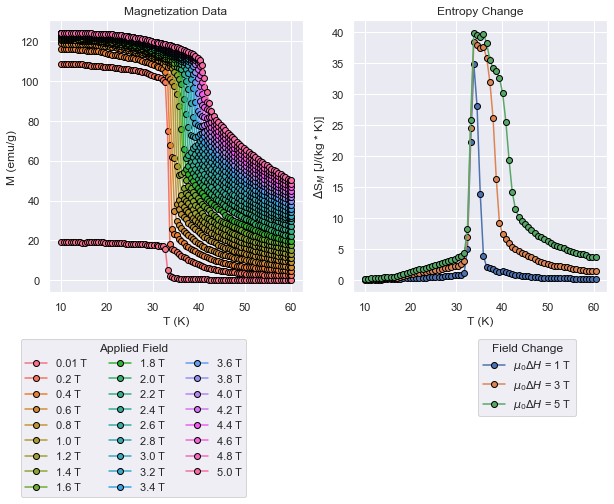

In [8]:
SAVED_WEIGHTS = "weights_deepmodelexample"
model = tf.keras.models.load_model(SAVED_WEIGHTS)
sim_data = generate_data(model = model, **simulation_paramaters)
deeper_sim = plot_entropy_curve(data=sim_data, 
                                temperature_column="t", 
                                field_column="h", 
                                magnetization_column="m",
                                bbox_mag = (0.8, -0.15), 
                                n_cols=3, 
                                bbox_ds = (0.9, -0.15), 
                                return_entropy = True)